## 3. Analyze interdependencies between movies.

RQ3: How does the premiere dates and "public" opinion on a movie and its sales interfere with the sales of another movie and its premiere data?

*Beware that the titles of the movies were never synchronised due to different people handling different data sets. We cannot save files from the box office data with filenames containing ':'. We cannot change these titles back to the original form since it was lost in the creation of the files. We can and will, however, dual-wield the two types of titles in order to have good plotting titles and other eye pleasers. The code can, therefore, be a bit odd to outsiders. We apologise for this inconvenience in advance.*

**Overview:**

Pick similarly budgeted movies released close to each other, investigate how distribution of quotes and box office data evolves over time.

Do Chi-square test of independence on the box office and quotes separatly.


Test whether quotes for movies are dependent on box office for movies (other way around sounds feacible) through a chi-square test.

Test if movies of the same budget (within a specific budget-range) are dependent on each other (their distributions match)

Maybe check if genres play a role?


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib
import datetime

import os
import glob

import warnings
warnings.filterwarnings('ignore')

In [73]:
data_dir = "data/"

daily_dir = 'data/time_series_box_office_data/'

path = os.getcwd()

path = os.path.join(path, daily_dir)

csv_files = glob.glob(os.path.join(path, '*.csv'))

movie_names = np.empty(len(csv_files),dtype='<U100')
daily = {}

for i,f in enumerate(csv_files):
    #Get the keys for our dictionary
    movie_names[i] = f[f.find('office_data'):]
    movie_names[i] = movie_names[i][movie_names[i].find('/'):]
    movie_names[i] = movie_names[i][:movie_names[i].find('___')]
    movie_names[i] = movie_names[i].replace('/','')
    # read the csv file
    daily[movie_names[i]] = pd.read_csv(f)

quotes = pd.read_pickle(data_dir+'Quotebank_wSentiment.pkl')


In [167]:
#This cell will get the titles and more to be examined (tm2e) by comparing the titles in the quotebank data and the daily gross data.
#Furthermore, it will also keep both the title versions. The daily as keys and the quotebank as items.
movie_titles = quotes['movie'].unique()
quote_titles = movie_titles.copy()
tm2e = {}#titles to examine

for i in range(len(movie_titles)):
    if '-' in movie_titles[i]:
        movie_titles[i] = movie_titles[i][:movie_titles[i].find(' - ')]
    movie_titles[i] = movie_titles[i].replace(':','')
    movie_titles[i] = movie_titles[i].replace(' ','_')
    for j in range(len(daily.keys())):
        if movie_titles[i] == list(daily.keys())[j]:
            tm2e[movie_titles[i]] = quote_titles[i]          

**3.1 - Check if movie quotes and box office are dependent on each other**

We will do this by first plotting a few movies in the same plot as their quotes with the x-axis being time
and the y-axis being box office and number of quotes. If the distributions match, we have an indication and visualisation that the box office is dependent on how much publicity (quotes) a movie recieves.

Afterwards, we will check that the distributions are truly the same with a Chi-square test. This will be done on all movies.

##We need data on the same timeline.. We need quotes to be at least the release year and the year after.

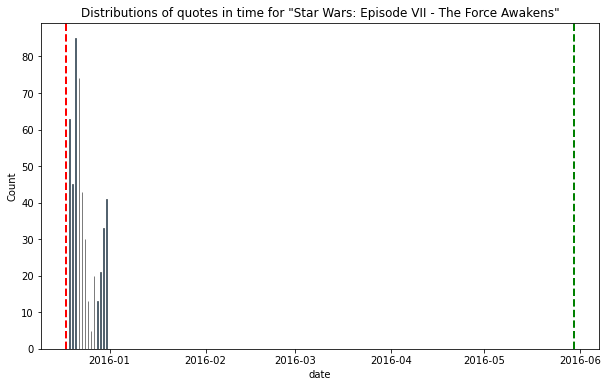

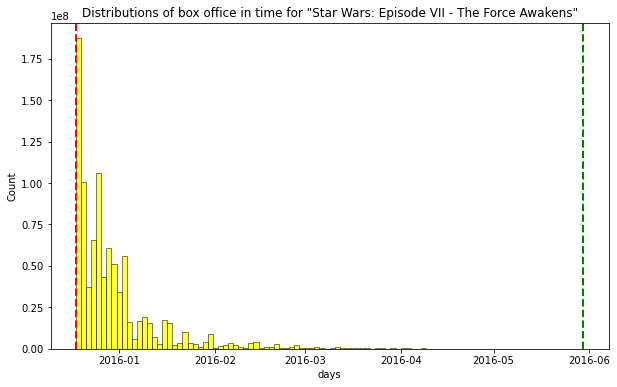

In [272]:
#Here we show Star Wars: Episode VII - The Force Awakens (qtitle), but you can change the title to any in tm2e.keys()!
title = 'Star_Wars_Episode_VII'
#title = 'Dolittle'
qtitle = tm2e[title]

plt_box = daily[title]
quotes['date'] = pd.to_datetime(quotes['date'])

#quotes plot, dont mind the titles and stuff :)
plt.figure(figsize = (10,6))
plt.title(f'Distributions of quotes in time for "{qtitle}"')
plt_quote = quotes[quotes['movie']==qtitle]
plt_quote = plt_quote[plt_quote['date']>pd.to_datetime(daily[title]['days'][0])]
plt_quote = plt_quote[plt_quote['date']<pd.to_datetime(daily[title]['days'][len(daily)])]

sns.histplot(data=plt_quote['date'], bins=100)
plt.axvline(pd.to_datetime(daily[title]['days'][0]), color='r', linestyle='dashed', linewidth=2) #Release
plt.axvline(pd.to_datetime(daily[title]['days'][len(plt_box)-1]), color='g', linestyle='dashed', linewidth=2) #taken off screen
plt.show()

#box office. We decided to convert it into a histogram to better compare with the quotes :D

plt.figure(figsize = (10,6))
plt.title(f'Distributions of box office in time for "{qtitle}"')
plt_box['days']=pd.to_datetime(plt_box['days'])
sns.histplot(x=plt_box['days'],weights=plt_box['daily'], bins=100, color='yellow')
plt.axvline(pd.to_datetime(daily[title]['days'][0]), color='r', linestyle='dashed', linewidth=2) #Release
plt.axvline(pd.to_datetime(daily[title]['days'][len(plt_box)-1]), color='g', linestyle='dashed', linewidth=2) #taken off screen
plt.show()

In [ ]:
'''
plt_quote_normalised = {}
for j in plt_quote['date'].unique():
    plt_quote_normalised[j] = (plt_quote['date']==j).sum()
plt_quote_normalised = pd.DataFrame(data=plt_quote_normalised.values(),index=plt_quote_normalised.keys())
plt_quote_normalised = (plt_quote_normalised-plt_quote_normalised.min())/(plt_quote_normalised.max()-plt_quote_normalised.min())
'''

## 3.1 Interdependencies Between Box Office for Movies

In this section we will check whether movies can influence the sale of other movies or not. For example: say a movie, A, is released on time, a. It makes big bucks because no other movie is competing with it. Suddenly the highly anticipated movie, B, is released at time, b. Will the box office of A be influenced by people who would rather go see B? This will be answered in this section, stay tuned!

Because this is mainly a plotting exercise, we will focus on two movies. The first movie is Zootopia and the second is Batman v Superman Dawn of Justice. They were released within the same most popular month in the most popular year (2016-y, 3-m). Unfortunatly, we do not have a lot of data, so we hope to see an interdependency between these two movies or other movies still running in theaters.

The next cell shows you how we picked the two movies (rather naively):

In [195]:
from collections import Counter
#Convert all timestamps into datetime objects for easier access and workability:
for i in daily.keys():
    daily[i]['days'] = pd.to_datetime(daily[i]['days'])

#Find a place in time where there is a high concentration of movies released within the same fortnight
all_release_dates = [daily[i]['days'][0] for i in daily.keys()]
Counter([all_release_dates[i].year for i in range(len(all_release_dates))])#We will say the year with the most activity is 2016 because Rogue 1 is released that year

all_release_dates = [i for i in all_release_dates if i.year == 2016]
Counter([all_release_dates[i].month for i in range(len(all_release_dates))]) #best month is 3. (March)

all_release_dates = [i for i in all_release_dates if i.month == 3]
all_release_dates #consists of two dates

#Index the movies with release dates of our two timestamps:
print([i for i in daily.keys() if daily[i]['days'][0] == all_release_dates[0]]) #Zootopia
print([i for i in daily.keys() if daily[i]['days'][0] == all_release_dates[1]]) #Batman v Superman dawn of peepeepoopoo

['Zootopia']
['Batman_v_Superman_Dawn_of_Justice']


Comparing these two movies just isnt enough for us, so we would like to get all movies who are currently in theaters in either of the two movies' release dates:

In [206]:
movie_interdependence_names = [i for i in daily.keys() if any(daily[i]['days'].isin(all_release_dates))]
print(movie_interdependence_names)

['Spectre', 'Zootopia', 'Deadpool', 'Star_Wars_Episode_VII', 'Batman_v_Superman_Dawn_of_Justice']


We have 5 movies to examine. Firstly, we will plot all the movies into the same histogram and see if there is any immediate interdependency visible:

(0.0, 80000000.0)

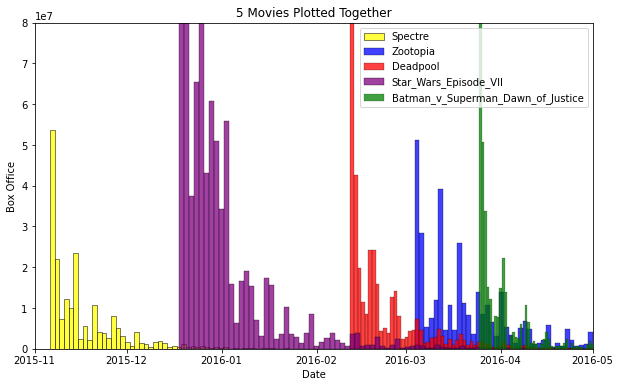

In [229]:
#Get the dataframes for all the five movies:
movie_interdependence_df = [daily[i] for i in movie_interdependence_names]

#Plot it :D
plt.figure(figsize = (10,6))
plt.title('5 Movies Plotted Together')
color=['yellow','blue','red','purple','green']

for i in range(5):
    sns.histplot(x=movie_interdependence_df[i]['days'],weights=movie_interdependence_df[i]['daily'], bins=100, color=color[i])
plt.legend(movie_interdependence_names)
plt.xlabel('Date')
plt.ylabel('Box Office')
plt.xlim(pd.Timestamp(2015,11,1),pd.Timestamp(2016,5,1))
plt.ylim(0,0.8e8)


Well that is a shame. It does not really look like movies influence each other. This may be due to the fact that movies tend to be released a few weeks apart from each other and that the audiences are different. It seems as though weekends are at the peaks and all movies just lose box office over time as more people have seen them. This could suggest that the average American just watches the movie he/she likes and does not have to pick between movies due to financial stress. And those people who are in financial stress is either a small marigin or do not go to the theaters at all.

If this is the case, the distributions should be similar for all movies. This leads us to 3.2:

## 3.2 Box Office Distributions Similarity

In this section, we will investigate whether distributions for box office are similar for all movies. Firstly, we will plot the standardised distributions in a histogram to see visualise the distributions:

In [243]:
daily['Spectre']

,Unnamed: 0,days,dow,rank,daily,theaters,special events
0,0,2015-11-06,Friday,1,27434579.0,3929,NaN
1,1,2015-11-07,Saturday,1,26283806.0,3929,NaN
2,2,2015-11-08,Sunday,1,16684763.0,3929,NaN
3,3,2015-11-09,Monday,1,5316879.0,3929,NaN
4,4,2015-11-10,Tuesday,1,7321682.0,3929,NaN
...,...,...,...,...,...,...,...
149,149,2016-04-03,Sunday,45,891.0,5,NaN
150,150,2016-04-04,Monday,51,146.0,5,NaN
151,151,2016-04-05,Tuesday,49,168.0,5,NaN
152,152,2016-04-06,Wednesday,52,60.0,5,NaN


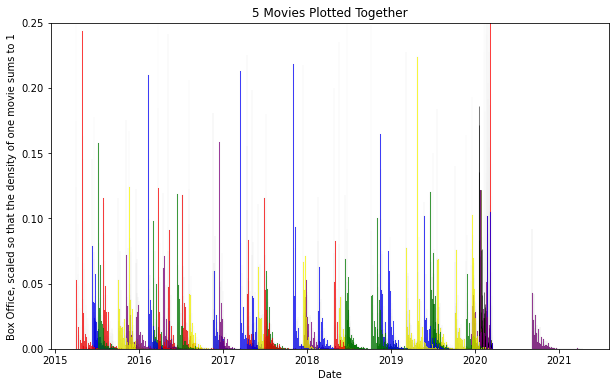

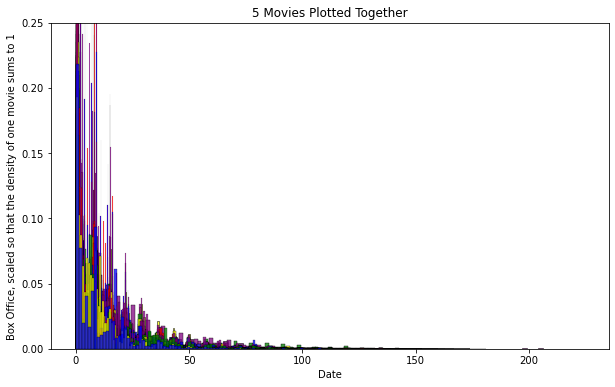

In [268]:
plt.figure(figsize = (10,6))
plt.title('5 Movies Plotted Together')
color=['yellow','blue','red','purple','green']

j=0
for i in daily.keys():
    if j > 4:
        j = 0
    sns.histplot(x=daily[i]['days'],weights=daily[i]['daily'], bins=100, stat='density', color=color[j])
    j+=1
plt.xlabel('Date')
plt.ylabel('Box Office, scaled so that the density of one movie sums to 1')
#plt.xlim(pd.Timestamp(2020,1,1),pd.Timestamp(2020,3,1))
plt.ylim(0,0.25)
plt.show()

plt.figure(figsize = (10,6))
plt.title('5 Movies Plotted Together')
color=['yellow','blue','red','purple','green']

j=0
for i in daily.keys():
    if j > 4:
        j = 0
    sns.histplot(x=daily[i].index,weights=daily[i]['daily'], bins=100, stat='density', color=color[j])
    j+=1
plt.xlabel('Date')
plt.ylabel('Box Office, scaled so that the density of one movie sums to 1')
#plt.xlim(pd.Timestamp(2020,1,1),pd.Timestamp(2020,3,1))
plt.ylim(0,0.25)
plt.show()

In [269]:
quotes

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,sentiment
0,"with the short and said, `We'd like to go with...",Al Jean,[Q2829373],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward,3832,6.0
1,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward,1151,5.0
2,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[Q24387573],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog,3155,5.0
3,The animals do what he wants but operate in co...,Stephen Gaghan,[Q1971984],2020-01-24,1,"[[Stephen Gaghan, 0.7508], [None, 0.2492]]",[http://nst.com.my/lifestyle/groove/2020/01/55...,Dolittle,2035,-5.0
4,`Dolittle' is a more harmless and whimsical fa...,Robert Downey,[Q165219],2020-01-18,1,"[[Robert Downey, 0.6829], [None, 0.2553], [Kat...",[http://gulfnews.com/entertainment/hollywood/r...,Dolittle,1168,0.0
...,...,...,...,...,...,...,...,...,...,...
44965,"We're maintaining their groups, their solo car...",Chris Lee,"[Q602180, Q1077464, Q22670603, Q42873342, Q162...",2019-08-08,1,"[[Chris Lee, 0.9288], [None, 0.0712]]",[https://www.forbes.com/sites/jeffbenjamin/201...,Avengers: Endgame,8035,6.0
44966,Endgame is being billed as the culmination of ...,Erik Davis,"[Q5388552, Q13533332]",2019-04-04,2,"[[Erik Davis, 0.866], [None, 0.1077], [Captain...",[https://comicbook.com/2019/04/04/avengers-end...,Avengers: Endgame,7152,3.0
44967,I appreciate when something is done incredibly...,Kevin Smith,"[Q6397520, Q489831, Q22681671, Q6397519, Q6397...",2019-08-22,2,"[[Kevin Smith, 0.6208], [None, 0.3793]]",[https://comicbook.com/marvel/2019/08/22/kevin...,Spider-Man: Far from Home,8547,8.0
44968,I think Fallen Order is going to offer a Star ...,Chris Avellone,[Q520809],2019-05-11,2,"[[None, 0.6466], [Chris Avellone, 0.3534]]",[https://comicbook.com/2019/05/11/star-wars-je...,Star Wars: Episode IX - The Rise of Skywalker,6728,2.0
